In [ ]:
%%bash
git clone https://github.com/Nazar1997/bioinformatics_school --recursive
pip install biopython

In [6]:
import pandas as pd
from tqdm import tqdm_notebook, tqdm
from collections import defaultdict
import numpy as np
import os
from bioinformatics_school.notebooks.Sparse_vector.sparse_vector import SparseVector
from joblib import load, dump, Parallel, delayed

taget_antigen = ['DNase-seq', 'Histone', 'RNA polymerase', 'TFs and others']
chroms = [f'chr3']

# DNA download

In [ ]:
%%bash
mkdir bioinformatics_school/data/mm9_dna
mkdir bioinformatics_school/data/mm9_dna/raw
mkdir bioinformatics_school/data/mm9_dna/sparse
cd bioinformatics_school/data/mm9_dna/raw
wget http://hgdownload.cse.ucsc.edu/goldenPath/mm9/chromosomes/chr3.fa.gz
gzip -d chr3.fa.gz

In [11]:
from Bio import SeqIO

for record in tqdm(SeqIO.parse("bioinformatics_school/data/mm9_dna/raw/chr3.fa", "fasta")):
    if record.id in chroms:
        dump(str(record.seq.upper()), f"bioinformatics_school/data/mm9_dna/sparse/{record.id}.pkl", 3)

1it [00:07,  7.68s/it]


In [68]:
dna = {chrom:load(f'bioinformatics_school/data/mm9_dna/sparse/{chrom}.pkl') for chrom in tqdm(chroms)}
lens_of_chroms = {chrom: len(dna[chrom]) for chrom in dna}

100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


# Target prepare

In [69]:
def processor(file):
    loc_dd = {chrm:SparseVector(lens_of_chroms[chrm]) for chrm in chroms}
    df = pd.read_csv(f'bioinformatics_school/data/mm9_zdna/raw/{file}', sep='\t', header=None)
    for chrom, sub_df in tqdm(df.groupby(0)):
        if chrom not in chroms:
            continue
        vec = np.zeros(lens_of_chroms[chrom])
        for inter in sub_df.values:
            vec[inter[1]:inter[2]+1] = np.maximum(vec[inter[1]:inter[2]+1], 1)
        loc_dd[chrom] = SparseVector(vec)

    dump(loc_dd, f'bioinformatics_school/data/mm9_zdna/sparse/{file[:-4]}.pkl', 3)

In [70]:
for file in os.listdir('bioinformatics_school/data/mm9_zdna/raw/'):
    if file.startswith("zdna_"):
        processor(file)

100%|██████████| 27/27 [00:01<00:00, 15.36it/s]


In [71]:
loc_dd = {chrm:SparseVector(lens_of_chroms[chrm]) for chrm in chroms}
df = pd.read_csv('bioinformatics_school/data/mm9_zdna/raw/blacklist_mm9.bed', sep='\t', header=None, names=range(3), index_col=False)
for chrom, sub_df in tqdm(df.groupby(0)):
    if chrom not in chroms:
        continue
    vec = np.zeros(lens_of_chroms[chrom])
    for inter in sub_df.values:
        vec[inter[1]:inter[2]+1] = np.maximum(vec[inter[1]:inter[2]+1], 1)
    loc_dd[chrom] = SparseVector(vec)
dump(loc_dd, f'bioinformatics_school/data/mm9_zdna/sparse/blacklist_mm9.pkl', 3)

100%|██████████| 24/24 [00:01<00:00, 21.66it/s]


['bioinformatics_school/data/mm9_zdna/sparse/blacklist_mm9.pkl']

# Model trainig

In [12]:
import pandas as pd
import numpy as np
import scipy
from tqdm import trange
from tqdm import tqdm
from datetime import datetime
import sys
import os
import seaborn as sns
from matplotlib import pyplot as plt
from joblib import Parallel, delayed, dump, load
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Choose visible device
# os.environ['CUDA_VISIBLE_DEVICES'] = '3'
# Select model number. From 0 to 4, as much as number of folds
MODEL_NUMBER = 0

In [13]:
chroms = [f'chr{i}' for i in list(range(1, 20)) + ['X', 'Y']]
all_features = sorted([i[:-4] for i in os.listdir('bioinformatics_school/data/mm9_features/sparse/') if i.endswith('.pkl')])

In [14]:
chroms = ['chr3']

In [15]:
groups = ['DNase-seq', 'Histone', 'RNA polymerase', 'TFs and others']
groups = ['Histone', 'RNA polymerase', 'TFs and others']
feature_names = [i for i in all_features if (i.split('_')[0] in groups)]


In [19]:
import sys
sys.path.append('./bioinformatics_school/notebooks/')

In [20]:
import Sparse_vector

In [21]:
ZDNA = load(f'bioinformatics_school/data/mm9_zdna/sparse/zdna_mm9.pkl')
black_list = load(f'bioinformatics_school/data/mm9_zdna/sparse/blacklist_mm9.pkl')

In [23]:
%%time
# load all the data
DNA = {chrom:load(f'bioinformatics_school/data/mm9_dna/sparse/{chrom}.pkl') for chrom in tqdm(chroms)}

DNA_features = {feture: load(f'bioinformatics_school/data/mm9_features/sparse/{feture}.pkl')
                for feture in tqdm(feature_names)}


100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

100%|██████████| 871/871 [00:01<00:00, 723.50it/s]

CPU times: user 2.05 s, sys: 150 ms, total: 2.2 s
Wall time: 2.25 s


In [24]:
for feature in tqdm(DNA_features):
    if set(DNA_features[feature].keys()) != set(chroms):
        for chrom in chroms:
            if chrom not in DNA_features[feature]:
                DNA_features[feature][chrom] = SparseVector(len(DNA[chrom]))


100%|██████████| 871/871 [00:00<00:00, 295282.80it/s]


# DL code

In [25]:
import torch
from torch.utils import data
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, StratifiedKFold

In [26]:
class Dataset(data.Dataset):
    def __init__(self, chroms, features, 
                 dna_source, features_source, 
                 labels_source, intervals):
        self.chroms = chroms
        self.features = features
        self.dna_source = dna_source
        self.features_source = features_source
        self.labels_source = labels_source
        self.intervals = intervals
        self.le = LabelBinarizer().fit(np.array([["A"], ["C"], ["T"], ["G"]]))
        zhunt = """CG 0.7 4.0 4.0 4.0
GC 4.0 0.7 4.0 4.0
CA 1.3 4.6 4.5 4.5
AC 4.6 1.3 4.5 4.5
TG 1.3 4.6 4.5 4.5
GT 4.6 1.3 4.5 4.5
TA 2.5 5.9 5.6 5.6
AT 5.9 2.5 5.6 5.6
CC 2.4 2.4 4.0 4.0
GG 2.4 2.4 4.0 4.0
CT 3.4 3.4 6.3 6.3
TC 3.4 3.4 6.3 6.3
GA 3.4 3.4 6.3 6.3
AG 3.4 3.4 6.3 6.3
AA 3.9 3.9 7.4 7.4
TT 3.9 3.9 7.4 7.4"""
        ZHUNT_AS = {line.split(' ')[0]:float(line.split(' ')[1]) 
              for line in zhunt.split('\n')}
        ZHUNT_SA = {line.split(' ')[0]:float(line.split(' ')[2]) 
              for line in zhunt.split('\n')}
        ZHUNT_ASd= {line.split(' ')[0]:float(line.split(' ')[3]) 
              for line in zhunt.split('\n')}
        ZHUNT_SAd= {line.split(' ')[0]:float(line.split(' ')[4]) 
              for line in zhunt.split('\n')}
        self.configs = {"ZHUNT_AS":ZHUNT_AS,
                       "ZHUNT_SA":ZHUNT_SA,
                       "ZHUNT_ASd":ZHUNT_ASd,
                       "ZHUNT_SAd":ZHUNT_SAd}
        
    def __len__(self):
        return len(self.intervals)
    
    def __getitem__(self, index):
        interval = self.intervals[index]
        chrom = interval[0]
        begin = int(interval[1])
        end = int(interval[2])
        
        ll = list(self.dna_source[chrom][begin:end].upper())
        dna_OHE = self.le.transform(ll)
        
        zhunts = []
        for key in self.configs:
            vec = np.array(ll)
            vec = np.vectorize(lambda x:self.configs[key].get(x, 0))(
                                    np.char.add(vec[1:], vec[:-1]))
            zhunts.append(np.concatenate([vec, [0]]))
        
        
        
        feature_matr = []
        for feature in self.features:
            source = self.features_source[feature]
            feature_matr.append(source[chrom][begin:end])
            
        if len(feature_matr) > 0:
            X = np.hstack((dna_OHE, 
                           np.array(zhunts).T,
                           np.array(feature_matr).T/1000)).astype(np.float32)
        else:
            X = dna_OHE.astype(np.float32)
        y = self.labels_source[interval[0]][interval[1]: interval[2]]
        
        
        
        return (X, y)
        
        

In [27]:
width = 5000

np.random.seed(10)

ints_in = []
ints_out = []


for chrm in chroms:
    for st in trange(0, ZDNA[chrm].shape - width, width):
        interval = [st, min(st + width, ZDNA[chrm].shape)]
        N_count = sum([bp == "N" for bp in DNA[chrm][interval[0]:interval[1]]])
        bl_count = black_list[chrm][interval[0]:interval[1]].sum()
        if N_count > width / 2 or bl_count > 0:
            continue
        else:
            if ZDNA[chrm][interval[0]: interval[1]].any():
                ints_in.append([chrm, interval[0], interval[1]])
            else:
                ints_out.append([chrm, interval[0], interval[1]])


                
                
print(len(ints_in))
print(len(ints_out))



100%|██████████| 31919/31919 [00:17<00:00, 1804.99it/s]

86
29549


In [28]:
np.random.seed(42)

ints_in = np.array(ints_in)
ints_out = np.array(ints_out)[np.random.choice(range(len(ints_out)), 
                                                          size=len(ints_in) * 3, replace=False)]

print(len(ints_in))
print(len(ints_out))

86
258


In [29]:
dna_lens = {i:len(DNA[i])for i in DNA}

In [30]:
ints_out = [i for i in ints_out if (int(i[1]) < dna_lens[i[0]]) and (int(i[2]) < dna_lens[i[0]])]

In [31]:
equalized = np.vstack((ints_in, ints_out))
equalized = [[inter[0], int(inter[1]), int(inter[2])] for inter in equalized]

In [32]:
divisions = list(StratifiedKFold(5, shuffle=True, 
                                 random_state=42).split(equalized, [f"{int(i < len(ints_in))}_{elem[0]}"
                                         for i, elem 
                                         in enumerate(equalized)]))

In [33]:
train_inds, test_inds = divisions[MODEL_NUMBER]


train_intervals, test_intervals = [equalized[i] for i in train_inds], [equalized[i] for i in test_inds]

train_dataset = Dataset(chroms, feature_names, 
                       DNA, DNA_features, 
                       ZDNA, train_intervals)

test_dataset = Dataset(chroms, feature_names, 
                       DNA, DNA_features, 
                       ZDNA, test_intervals)

In [40]:
from torch import nn
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, f1_score
from IPython.display import clear_output

class DeepZ(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.LSTM(879, 100, 1, bidirectional=True)
        self.seq = nn.Sequential(
                nn.Linear(2 * 100, 100),
                nn.Sigmoid(),
                nn.Dropout(0.25),
                nn.Linear(100, 2)
        )
    
    def forward(self, x):
        x, (h_n, c_n) = self.rnn(x)
        x = self.seq(x)
        return F.log_softmax(x, dim=-1)

In [41]:
params = {'batch_size':30,
          'num_workers':5,
          'shuffle':True}

loader_train = data.DataLoader(train_dataset, **params)
loader_test = data.DataLoader(test_dataset, **params)


train_log, train_acc_log, train_auc_log, train_f1_log = [], [], [], []
val_log,   val_acc_log,   val_auc_log, val_f1_log   = [], [], [], []
# best_auc = 0
# log = open(f"../models/{ASSEMBLY}/log_{MODEL_NUMBER}", 'w')
# log.write(datetime.now().strftime("%d/%m/%Y %H:%M:%S") + "\n")
# log.close()
    
def loss_func(output, y_batch):
    return torch.nn.NLLLoss()(torch.transpose(output, 2, 1), y_batch)

def train_epoch(model, optimizer):
    loss_log, acc_log, roc_auc_log, f1_log = [], [], [], []
    model.train()
    for X_batch, y_batch in tqdm(loader_train):
        X_batch, y_batch = X_batch.cuda(), y_batch.cuda().long()
        optimizer.zero_grad()
        output = model(X_batch)
        pred = torch.argmax(output, dim=2)
        y_pred = nn.Softmax(dim=1)(output)[:, :,1].detach().cpu().numpy().flatten()
        if np.std(y_batch.cpu().numpy().flatten()) == 0:
            roc_auc = 0
        else:
            roc_auc = roc_auc_score(y_batch.cpu().numpy().flatten(),
                                    nn.Softmax(dim=1)(output)[:, :,1].detach().cpu().numpy().flatten())
        f1_log.append(f1_score(y_batch.cpu().numpy().flatten(),
                         pred.cpu().numpy().flatten()))
        roc_auc_log.append(roc_auc)
        acc = torch.mean((pred == y_batch).float())
        acc_log.append(acc.cpu().numpy())
        loss = loss_func(output, y_batch)
        loss.backward()
        optimizer.step()
        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log, roc_auc_log, f1_log

def test(model):
    loss_log, acc_log, roc_auc_log, f1_log = [], [], [], []
    model.eval()
    means = []
    for X_batch, y_batch in tqdm(loader_test):
        X_batch, y_batch = X_batch.cuda(), y_batch.cuda().long()
        output = model(X_batch)
        means.append(y_batch.sum().cpu() / (1.0 * y_batch.shape[0]))
        pred = torch.argmax(output, dim=2)
        if np.std(y_batch.cpu().numpy().flatten()) == 0:
            roc_auc = 0
        else:
            roc_auc = roc_auc_score(y_batch.cpu().numpy().flatten(),
                                    nn.Softmax(dim=1)(output)[:, :,1].detach().cpu().numpy().flatten())
        f1_log.append(f1_score(y_batch.cpu().numpy().flatten(),
                                  pred.cpu().numpy().flatten()))
        roc_auc_log.append(roc_auc)
        acc = torch.mean((pred == y_batch).float())
        acc_log.append(acc.cpu().numpy())
        loss = loss_func(output, y_batch)
        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log, roc_auc_log, f1_log

def plot_history(train_history, valid_history, title, BatchSize, epoch_to_show=20):
    plt.figure(figsize=(epoch_to_show, 4))
    plt.title(title)    
    
    epoch_num = len(valid_history)
    train_history = np.array([None] * (BatchSize * epoch_to_show) + train_history)
    valid_history = np.array([None] * epoch_to_show + valid_history)
    
    plt.plot(np.linspace(epoch_num-epoch_to_show+1, epoch_num+1, (epoch_to_show+1)*BatchSize), 
             train_history[-(epoch_to_show+1)*BatchSize:], c='red', label='train')
    plt.plot(np.linspace(epoch_num-epoch_to_show+1, epoch_num+1, epoch_to_show+1),
                valid_history[-epoch_to_show-1:], c='green', label='test')
    
    plt.ylim((0, 1))
    plt.yticks(np.linspace(0, 1, 11))
    plt.xticks(np.arange(epoch_num-epoch_to_show+1, epoch_num+2), 
              np.arange(epoch_num-epoch_to_show, epoch_num+1).astype(int))
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
def train(model, opt, n_epochs):
    global best_auc
    for epoch in range(n_epochs):
        print("Epoch {} of {}".format(epoch + 1, n_epochs))
        train_loss, train_acc, train_auc, train_f1 = train_epoch(model, opt)
        val_loss, val_acc, val_auc, val_f1 = test(model)
        
        BatchSize = len(train_loss)
        
        train_log.extend(train_loss)
        train_acc_log.extend(train_acc)
        train_auc_log.extend(train_auc)
        train_f1_log.extend(train_f1)

        val_log.append(np.mean(val_loss))
        val_acc_log.append(np.mean(val_acc))
        val_auc_log.append(np.mean(val_auc))
        val_f1_log.append(np.mean(val_f1))
        
        if (epoch % 1) == 0:
            clear_output()
            plot_history(train_log,     val_log,     'Loss',     BatchSize)    
            plot_history(train_acc_log, val_acc_log, 'Accuracy', BatchSize)
            plot_history(train_auc_log, val_auc_log, 'Auc',      BatchSize)
            plot_history(train_f1_log, val_f1_log,   'F1',       BatchSize)
            print("Epoch {} AUC = {:.2%}".format(epoch+1, val_auc_log[-1]))
            print("Epoch {} accuracy = {:.2%}".format(epoch+1, val_acc_log[-1]))
            
#             if val_auc_log[-1] > best_auc:
#                 best_auc = val_auc_log[-1]
#                 torch.save(model.state_dict(), f"../models/{ASSEMBLY}/model_{MODEL_NUMBER}")
#                 log = open(f"../models/{ASSEMBLY}/log_{MODEL_NUMBER}", 'a')
#                 log.write(str(best_auc) + "\n")
#                 log.close()
            
    print("Final AUC: {:.2}".format(1 - val_auc_log[-1]))

In [42]:
torch.cuda.empty_cache()

In [43]:
def count_parameters(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    return sum([np.prod(p.size()) for p in model_parameters])

In [44]:
model = DeepZ()
model = model.cuda()
print("Total number of trainable parameters:", count_parameters(model))

Total number of trainable parameters: 805102


In [ ]:
opt = torch.optim.RMSprop(model.parameters(), lr=10**-3, weight_decay=10**-3)
train(model, opt, 30)

In [46]:
class linear_DeepZ(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
                nn.Linear(879, 2)
        )
    
    def forward(self, x):
        x = self.seq(x)
        return F.log_softmax(x, dim=-1)

In [48]:
model = linear_DeepZ()
model = model.cuda()
print("Total number of trainable parameters:", count_parameters(model))

Total number of trainable parameters: 1760


In [ ]:
opt = torch.optim.RMSprop(model.parameters(), lr=10**-3, weight_decay=10**-3)
train(model, opt, 30)

In [57]:
weights = model.seq[0].cpu().weight.detach().numpy()

In [59]:
coef = weights[0] - weights[1]

In [61]:
feus = ["DNA_A", "DNA_C", "DNA_T", "DNA_G"] + ["ZHUNT_AS", "ZHUNT_SA", "ZHUNT_ASd","ZHUNT_SAd"] + \
       train_dataset.features

In [64]:
smth = sorted([(j, i) for i,j in zip(feus, coef)])

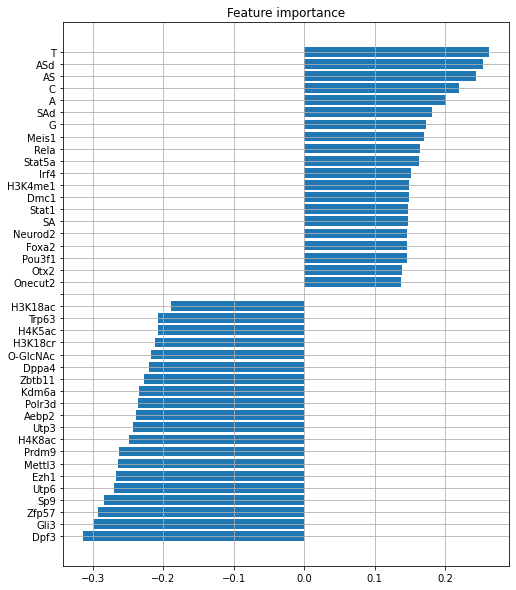

In [65]:
plt.figure(figsize=(8, 10))
plt.barh(np.arange(41), [i[0] for i in smth[:20]] + [0] + [i[0] for i in smth[-20:]])
plt.grid()
plt.title("Feature importance")
plt.yticks(np.arange(41), 
           [i.split("_")[1] 
            for i in [i[1] for i in smth[:20]] + ["_"] + [i[1] for i in smth[-20:]]], 
#            rotation='vertical'
          )
# plt.ylim(-12, 12)
# plt.savefig('feature_importance_Z22.pdf', bbox_inches='tight')
plt.show()